<a href="https://colab.research.google.com/github/summerolmstead/quantumworkshop/blob/main/Copy_of_QML_WorkShop2024_Chapter_3_Training_a_Quantum_Model_on_a_Real_Dataset_shared_audiences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

__Author__ : "Amin Amiri"


__Version__ : "v07082024-1817"


__*The University of Tennessee at Chattanooga*__

[Reference](https://qiskit-community.github.io/qiskit-machine-learning/index.html)

# Install necessary libraries

In [ ]:
%%capture

!pip install qiskit-machine-learning pylatexenc

# Step 1: Exploratory Data Analysis

## 1.1 Load the Dataset

In [ ]:
from sklearn.datasets import load_iris

# load the Iris dataset
iris_data = load_iris()


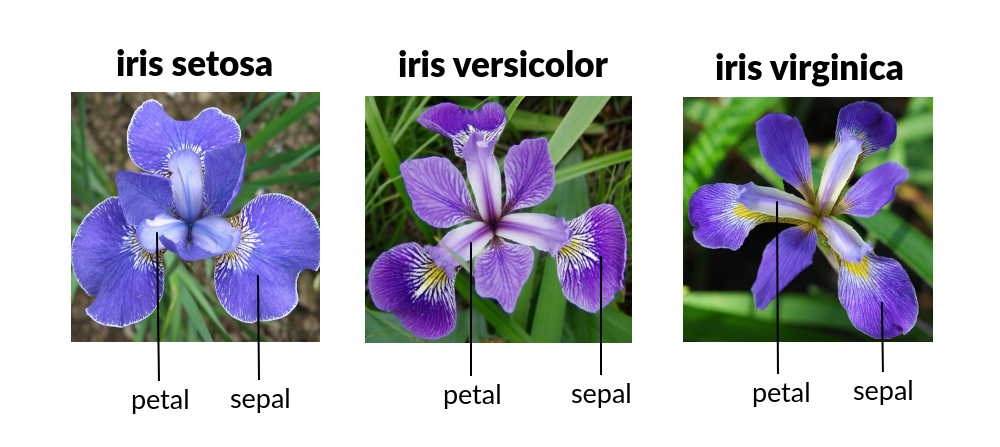

## 1.2 Print Dataset Description

In [ ]:
# print the description of the dataset to understand its structure and characteristics
print(iris_data.DESCR)


.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## 1.3 Extract Features and Labels

In [ ]:
# extract the features (data) and labels (target) from the dataset
features = iris_data.data
labels = iris_data.target


## 1.4 Normalize the Features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# normalize the features to the range [0, 1] for better numerical stability
features = MinMaxScaler().fit_transform(features)


## 1.5 Visualize the Data

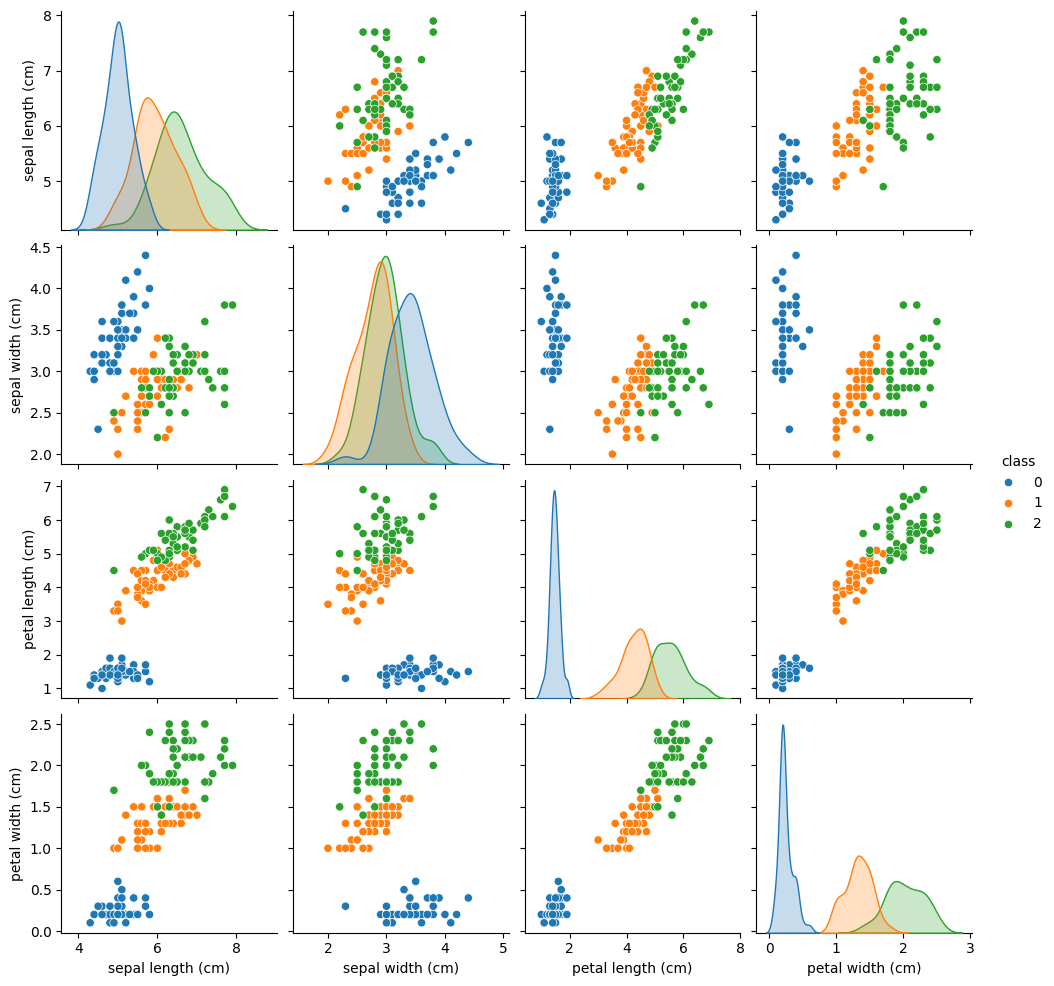

In [ ]:
import pandas as pd
import seaborn as sns

# create a DataFrame for easier visualization
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

# plot the features pair-wise to see if there's an observable correlation between them
sns.pairplot(df, hue="class", palette="tab10")


# Step 2: Training a Classical Machine Learning Model

## 2.1 Split the Dataset

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

# set a random seed for reproducibility
algorithm_globals.random_seed = 123

# split the dataset into training and testing sets (80% training, 20% testing)
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed #set constant seed
)


## 2.2 Train the Classical Model

In [ ]:
from sklearn.svm import SVC

# initialize and train a Support Vector Classifier (SVC) with default parameters
svc = SVC()
_ = svc.fit(train_features, train_labels)  # Suppress printing the return value


## 2.3 Evaluate the Classical Model

In [ ]:
# evaluate the trained model on the training and testing datasets
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

# print the performance scores
print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")


Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


# Step 3: Training a Quantum Machine Learning Model

## 3.1 Define the Feature Map

In [ ]:
from qiskit.circuit.library import ZZFeatureMap

# define a feature map to encode classical data into quantum states
num_features = features.shape[1]  #the number of features in the dataset
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)


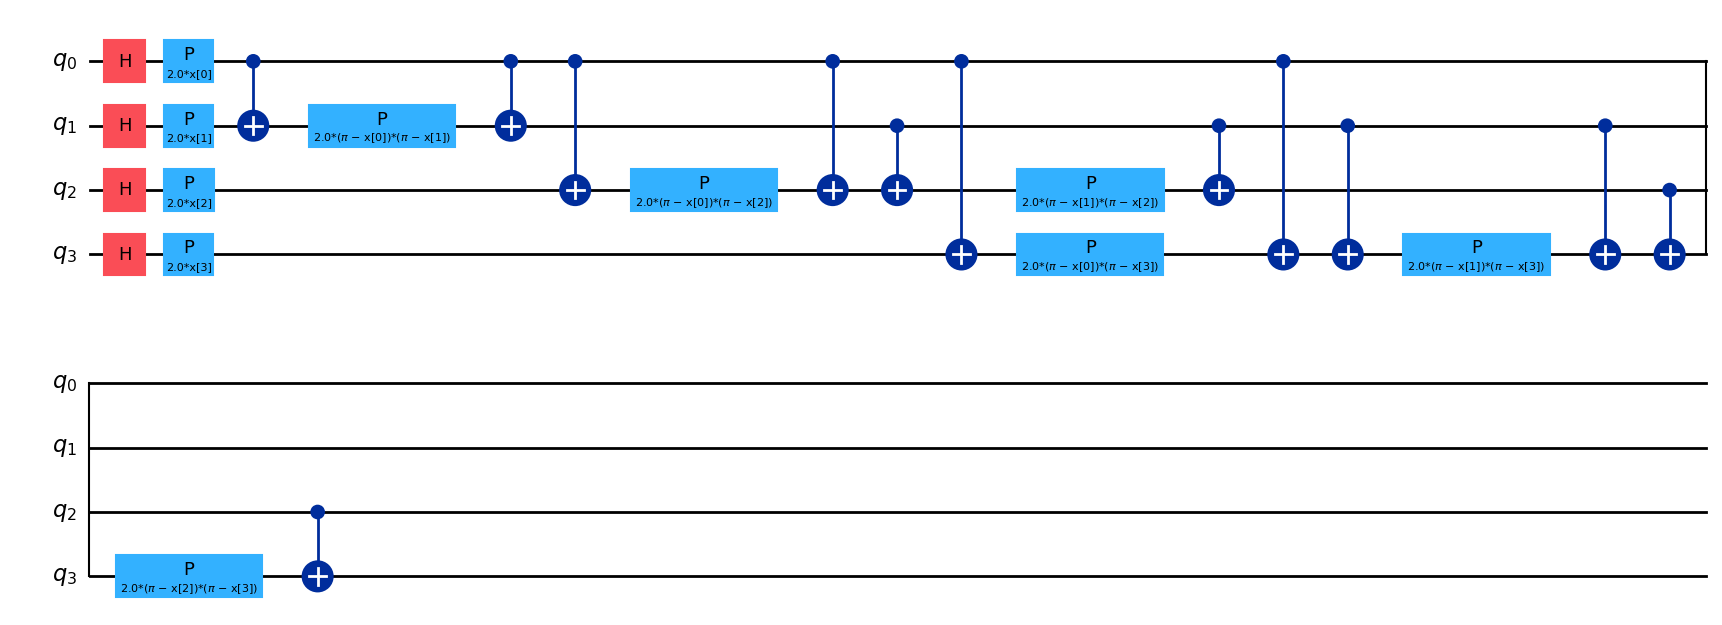

In [ ]:
feature_map.decompose().draw('mpl')

## 3.2 Define the Ansatz

In [ ]:
from qiskit.circuit.library import RealAmplitudes

# define an ansatz (parameterized quantum circuit) for the VQC
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)


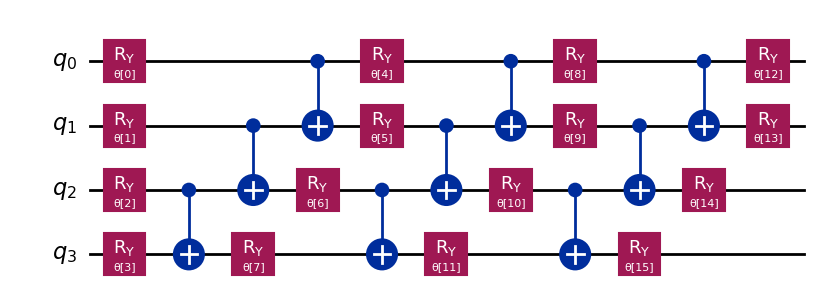

In [ ]:
ansatz.decompose().draw('mpl')

## 3.3 Define the Optimizer

In [ ]:
from qiskit_algorithms.optimizers import COBYLA

# use the COBYLA optimizer with a maximum of 100 iterations
optimizer = COBYLA(maxiter=100) #you can adjust


## 3.4 Create the Sampler

In [ ]:
from qiskit.primitives import Sampler

# create a sampler instance to simulate quantum circuits
sampler = Sampler()


## 3.5 Define the Callback Function

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

# initialize an array to store the objective function values
objective_func_vals = []

# configure the plot size
plt.rcParams["figure.figsize"] = (12, 6)

# deffine a callback function to update the plot at each iteration
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


## 3.6 Train the Quantum Model

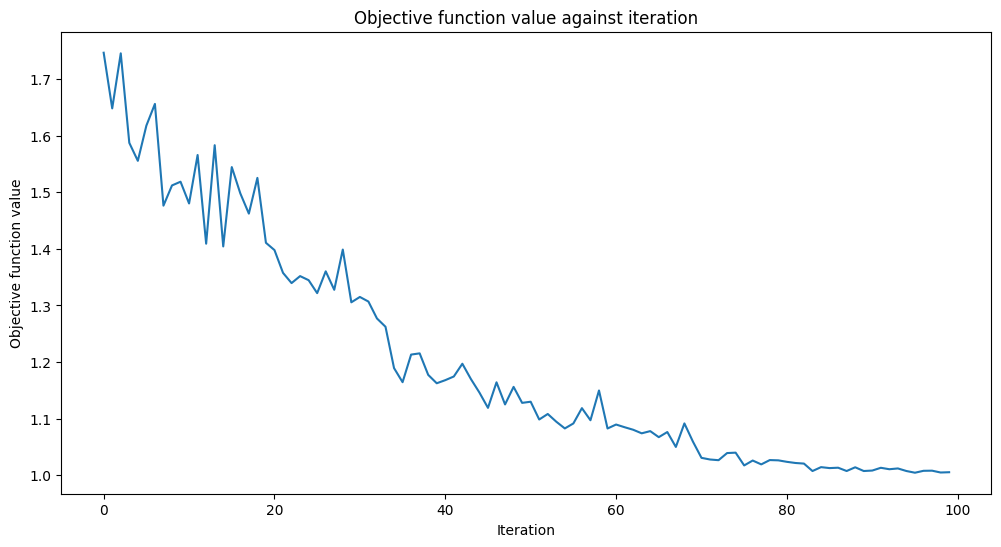

Training time: 116 seconds


In [ ]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

# initialize the VQC with the defined feature map, ansatz, optimizer, and sampler
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear the objective function values history
objective_func_vals = []

# masure the training time
start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

# print the training time
print(f"Training time: {round(elapsed)} seconds")


## 3.7 Evaluate the Quantum Model

In [ ]:
# evaluate the trained VQC on the training and testing datasets
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

# print the performance scores
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")

print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")


Quantum VQC on the training dataset: 0.85
Quantum VQC on the test dataset:     0.87
